# Tutorial de PyTorch: De Regresión a Transfer Learning

Este tutorial introduce PyTorch, una popular librería de aprendizaje profundo. 
Consta de dos partes:

1.  **Regresión con una Red Neuronal Multicapa (MLP):** Construiremos un MLP simple para predecir valores contínuos usando el conjunto de datos de Boston Housing.
2.  **Aprendizaje por Transferencia (Transfer Learning):** Usaremos un modelo pre-entrenado para una tarea de clasificación de imágenes.

## Parte 1: Regresión con un MLP

### Cargar y Preparar los Datos

In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

# Cargar los datos
file_path = '../data/BostonHousing_adj.csv'
data = pd.read_csv(file_path)

# Separar características (X) y variable objetivo (y)
X = data.drop('MEDV', axis=1)
y = data['MEDV']

# Convertir a tensores de PyTorch
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Crear un TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Extraer tensores de los datasets
X_train_tensor, y_train_tensor = train_dataset.dataset.tensors[0][train_dataset.indices], train_dataset.dataset.tensors[1][train_dataset.indices]
X_test_tensor, y_test_tensor = test_dataset.dataset.tensors[0][test_dataset.indices], test_dataset.dataset.tensors[1][test_dataset.indices]

# Escalar las características
mean = X_train_tensor.mean(dim=0)
std = X_train_tensor.std(dim=0)
X_train_scaled = (X_train_tensor - mean) / std
X_test_scaled = (X_test_tensor - mean) / std

# Crear DataLoaders con los datos escalados
train_dataset_scaled = TensorDataset(X_train_scaled, y_train_tensor)
test_dataset_scaled = TensorDataset(X_test_scaled, y_test_tensor)

train_loader = DataLoader(train_dataset_scaled, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_scaled, batch_size=32, shuffle=False)

### Definir el Modelo MLP

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Instanciar el modelo
input_size = X_train_scaled.shape[1]
model = MLP(input_size)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


### Definir la Función de Pérdida y el Optimizador

In [4]:
# Función de pérdida
criterion = nn.MSELoss()

# Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Entrenar el Modelo

In [7]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [10/100], Train Loss: 10.6903, Val Loss: 20.5347
Epoch [20/100], Train Loss: 10.1529, Val Loss: 20.1515
Epoch [30/100], Train Loss: 9.7566, Val Loss: 19.8746
Epoch [40/100], Train Loss: 9.4604, Val Loss: 19.6120
Epoch [50/100], Train Loss: 9.1184, Val Loss: 19.1441
Epoch [60/100], Train Loss: 8.8242, Val Loss: 19.1192
Epoch [70/100], Train Loss: 8.5686, Val Loss: 18.2987
Epoch [80/100], Train Loss: 8.3248, Val Loss: 17.6388
Epoch [90/100], Train Loss: 8.0848, Val Loss: 17.3041
Epoch [100/100], Train Loss: 7.8292, Val Loss: 17.1190


### Evaluar el Modelo

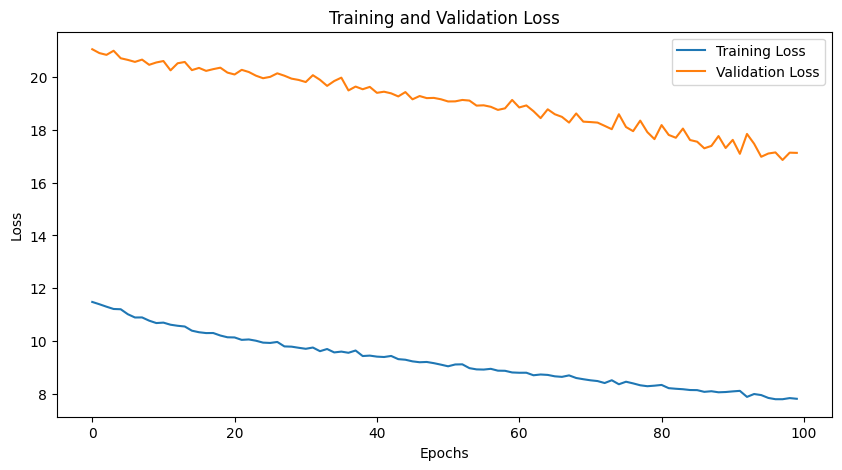

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
model.eval()
with torch.no_grad():
    total_loss = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
    
    avg_loss = total_loss / len(test_loader)
    print(f'Mean Squared Error en el conjunto de prueba: {avg_loss:.4f}')

Mean Squared Error en el conjunto de prueba: 15.3641


In [11]:
# Tomar una fila del conjunto de datos de prueba como datos no vistos
unseen_data_tensor = X_test_tensor[0:1]  # Tomamos la primera fila, manteniendo las dimensiones
actual_price_tensor = y_test_tensor[0:1]

# Escalar los datos con la misma media y desviación estándar que los datos de entrenamiento
unseen_data_scaled = (unseen_data_tensor - mean) / std

# Hacer una predicción
model.eval()
with torch.no_grad():
    predicted_price = model(unseen_data_scaled)

print(f"Datos de entrada (sin escalar): {unseen_data_tensor.numpy()}")
print(f"Datos de entrada (escalados): {unseen_data_scaled.numpy()}")
print(f"Precio predecido: {predicted_price.item():.4f}")
print(f"Precio real: {actual_price_tensor.item():.4f}")

Datos de entrada (sin escalar): [[  6.80117   0.       18.1       0.        0.713     6.081    84.4
    2.7175   24.      666.       20.2      14.7    ]]
Datos de entrada (escalados): [[ 0.43052208 -0.47848633  1.0038695  -0.27774432  1.308154   -0.3062454
   0.53424114 -0.49133134  1.6419628   1.5204508   0.8249208   0.2575909 ]]
Precio predecido: 16.1694
Precio real: 20.0000


### Inferencia con datos no vistos

## Parte 2: Aprendizaje por Transferencia (Transfer Learning)

En esta sección, utilizaremos un modelo pre-entrenado en un gran conjunto de datos de imágenes (ImageNet) y lo adaptaremos para una nueva tarea de clasificación de imágenes con un conjunto de datos más pequeño (CIFAR-10).

### Cargar Datos y Transformaciones

In [12]:
import torchvision
import torchvision.transforms as transforms

# Transformaciones para los datos de CIFAR-10
transform = transforms.Compose(
    [transforms.Resize(224),  # Redimensionar para el modelo pre-entrenado
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Descargar y cargar los datos de entrenamiento
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# Descargar y cargar los datos de prueba
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%
c:\Users\mateo\miniconda3\envs\torch2\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Función para mostrar una imagen
def imshow(img):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Obtener algunas imágenes de entrenamiento aleatorias
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Mostrar imágenes y etiquetas
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

### Cargar el Modelo Pre-entrenado y Modificar el Clasificador

In [13]:
import torchvision.models as models

# Cargar un modelo ResNet18 pre-entrenado
model_tl = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Congelar todos los parámetros del modelo
for param in model_tl.parameters():
    param.requires_grad = False

# Reemplazar la última capa (el clasificador)
num_ftrs = model_tl.fc.in_features
model_tl.fc = nn.Linear(num_ftrs, 10) # 10 clases para CIFAR-10

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_tl = model_tl.to(device)

print("Modelo modificado para Transfer Learning:")
print(model_tl.fc)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\mateo/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


Modelo modificado para Transfer Learning:
Linear(in_features=512, out_features=10, bias=True)


### Definir la Función de Pérdida y el Optimizador para Transfer Learning

In [14]:
# Función de pérdida para clasificación
criterion_tl = nn.CrossEntropyLoss()

# Optimizador (solo optimizará los parámetros del clasificador)
optimizer_tl = torch.optim.SGD(model_tl.fc.parameters(), lr=0.001, momentum=0.9)

### Entrenar el Modelo de Transfer Learning

In [ ]:
num_epochs_tl = 5
for epoch in range(num_epochs_tl):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Obtener los inputs; data es una lista de [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Poner a cero los gradientes del optimizador
        optimizer_tl.zero_grad()

        # Forward pass
        outputs = model_tl(inputs)
        loss = criterion_tl(outputs, labels)
        
        # Backward pass y optimización
        loss.backward()
        optimizer_tl.step()

        # Imprimir estadísticas
        running_loss += loss.item()
        if i % 200 == 199:    # Imprimir cada 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

### Evaluar el Modelo de Transfer Learning

In [ ]:
correct = 0
total = 0
# Como no estamos entrenando, no necesitamos calcular los gradientes
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # Calcular las salidas pasando las imágenes a través de la red
        outputs = model_tl(images)
        # La clase con la energía más alta es la que elegimos como predicción
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')